# Lab #5. Semi-Stochastic Gradient Descent

by Peter Richtarik

The purpose of today's lab is to fool around with an efficient randomized algorithm for <i>minimizing finite sums</i>. We will work with Semi-stochastic Gradient Descent (S2GD) [3,4,5]. This algorithm has the same theoretical complexity as dfSDCA [1,2]. However, it operates very differently. Papers [3,4] describe the basic method - which works with one example (function) at a time, chosen uniformly at random. Generalization to a subset of examples (among other things) was done in [5]. The important distinction compared to dfSDCA is that S2GD does not need to keep many dual variables. Therefore, its memory footprint is much smaller. This is of extreme importance in training models such as Neural Networks. So, for this reason, S2GD is well suited for training NNs, but dfSDCA is not.

## The problem

We will be minimizing the average of $n$ smooth convex functions over a closed convex set $Q$: 

$$\min_{x\in Q \subseteq \mathbb{R}^d} \left\{ F(x) \equiv \frac{1}{n}\sum_{i=1}^n f_i(x) \right\},$$

using S2GD. We shall only experiment with the basic variant as described in [3].

## Assumptions

The analysis depends on the follwoing 3 assumptions.

<b>Assumption 1.</b> The functions $f_i:\mathbb{R}^d\mapsto \mathbb{R}$, $i=1,\dots,n$, are $L$-smooth. That is, for all $x,y\in \mathbb{R}^d$ the following inequality holds:

$$\| \nabla f_i(x) - \nabla f_i(y) \|_2 \leq L\|x-y\|_2.$$

This is equivalent to requiring that for all $x,h\in \mathbb{R}^d$ one has

$$ f_i(x+h) \leq f_i(x) + (\nabla f_i(x))^\top h + \frac{L}{2}\|h\|_2^2.$$

<b>Assumption 2.</b>  The  functions $f_i:\mathbb{R}^d \mapsto \mathbb{R}$, $i=1,\dots,n$, are convex. That is, for all $x,h\in \mathbb{R}^d$:

$$f_i(x) + (\nabla f_i(x))^\top h \leq f_i(x+h).$$

<b>Assumption 3.</b> The function $F$ is $\mu$-strongly convex  for $\mu>0$. That is, for all $x,h\in \mathbb{R}^d$:

$$F(x) + (\nabla F(x))^\top h + \frac{\mu}{2}\|h\|_2^2 \leq F(x+h).$$

## S2GD algorithm

1) Parameters: 

- stepsize $h>0$
- number of outer iterations $T$
- number of inner iteration $m$
- starting point $x\in \mathbb{R}^d$

2) For $t=0,1,\dots,T$, repeat

2.1) Compute $G = \nabla F(x)$, set $x_{old} = x$

2.2) For $k = 1, 2, \dots, m$, repeat:
- Draw $i\in \{1,2,\dots,n\}$, uniformly at random
- Compute 2 stochastic gradients, one at the fresh point and at the old point: $\nabla f_i(x)$ and $\nabla f_i(x_{old})$
- Apply update: $x\leftarrow x - h (G + \nabla f_i(x) - \nabla f_i(x_{old}))$

## Basic theory

<b> Theorem [3,4,5].</b> Under Assumptions 1, 2 and 3, after $k = O((n+\kappa)\log(1/\epsilon))$ stochastic gradient evaluations, where $\kappa = \frac{L}{\mu}$, S2GD outputs a solution for which 

$$\mathbf{E}[F(x_k)-F(x_*)] \leq \epsilon (F(x_0)-F(x_*)).$$

Since $n$ stochastic gradient evaluations is equivalent workload to 1 pass over data (and to 1 gradient step), S2GD only needs $O((1+\kappa/n)\log(1/\epsilon))$ passes over data. In ML applications, usally $\kappa\approx n$. Hence $\tilde{O}(1)$ passes over data will do! This rate is the same as that of dfSDCA and Quartz, when these are specialized to the serial uniform sampling ($\hat{S}=\{i\}$ with probability $1/n$).

In practice one can try to apply the method via various tricks, and with mixed success, to some functions which do not satisfy thee assumptions. Notably, strong convexity is not needed: the method can be shown to work also without it (but it is slower). Likewise, one can try to apply the method even if $f$ is not convex (such as in the case of NNs). Experiments show that one gets state-of-the-art or close performance this way.
 
## References

- [1] S. Shalev-Shwartz. SDCA without duality, ICML 2015 [arXiv:1502.06177]
- [2] D. Csiba and P. Richtarik. Primal method for ERM with flexible mini-batching schemes and non-convex losses,
arXiv:1506.02227, 2015
- [3] J. Konecny and P. Richtarik. Semi-stochastic gradient descent. arXiv:1312.1666, 2013
- [4] R. Johnson and R. Zhang. Accelerating stochastic gradient descent using predictive variance reduction. Neural Information Processing Systems, 2013
- [5] J. Konecny, Jie Liu, Peter Richtarik and Martin Takac. Mini-batch semi-stochastic gradient descent in the proximal setting, IEEE Journal of Selected Topics in Signal Processing, 2015 [arXiv:1504.04407]

## Step 1 - Ridge regression

We will minimize the function:

$$F(x) = \frac{1}{2n}\sum_{i=1}^n (X_i^T x - y_i)^2  + \frac{\mu}{2}\|x\|_2^2,$$

where  $X_1,\dots,X_n \in \mathbb{R}^d$, $y_1,\dots,y_n\in \mathbb{R}$  and $\mu>0$. It is easy to see that $F(x)=\frac{1}{n}\sum_{i=1}^n f_i(x)$, where

$$ f_i(x) = \frac{1}{2} (X_i^T x - y_i)^2 + \frac{\mu}{2}\|x\|_2^2.$$

Also notice that the gradient of $f_i$ is given by:

$$\nabla f_i(x) =  (X_i^T x-y_i)X_i + \mu x.$$

We assume that $X_1,\dots,X_n \in \mathbb{R}^d$ are stored as the columns of a $d\times n$ matrix $X$ (technically, a "sparse matrix" in Julia). We also assume that the associated labels $y_1,\dots,y_n\in \mathbb{R}$ are stored as entries of a vector  $y\in \mathbb{R}^n$ (technically, an "array" in Julia).

It can be verified that $f_i$ is $L_i$-smooth and convex, with 

$$L_i = \|X_i\|_2^2 + \mu,$$ 

consequence of which is that all functions $f_i$ are $L$-smooth, where

$$L = \max_i L_i.$$

We now define a function $\verb"Loss_quadratic"$, whose output will be 3 functions and one scalar:
- function $\verb"f(x,i)"$ (=$f_i(x)$)
- function $\verb"g(x,i)"$ (=$\nabla f_i(x)$)
- function $\verb"F(x)"$   (=$F(x)$)
- scalar   $\verb"L"$      (=$L$)  

In [1]:
function Loss_quadratic(X::SparseMatrixCSC, y::Array{Float64,1}, μ::Float64)
    
    n = size(X)[2]
    f(x, i) = (1/2)*((X[:,i]'*x)[1] - y[i])^2 + (μ/2)*(norm(x)^2)       # function f_i
    g(x, i) = ((X[:,i]'*x)[1] - y[i]) * X[:,i] + μ*x                     # gradient of f_i
    F(x)    = (1/n)*sum([f(x,i) for i=1:n])                     # compute the function value
    L       = maximum([norm(X[:,i])^2 + μ for i=1:n])            # compute maximum of the Lipschitz constants
    
    return (g, f, F, L)
    
end

Loss_quadratic (generic function with 1 method)

## Step 2 - The S2GD algorithm

We now code up the algorithm itself...

In [2]:
function S2GD(g::Function, F::Function, x0::Array{Float64,1}, n::Int64, T::Int64, m::Int64, h::Float64, track::Bool, progress::Bool)        
    
    x = x0   # the starting point 
    
    if track
        F_values = zeros(T+1) # prepares the array of Function Values
        F_values[1] = F(x)
        if progress            
            println("#Starting function value: $(0), function value: $(F_values[1])")
        end        
    else
        if progress            
             println("#Starting function value: $(F(x))")        
        end                
    end
        
    for t=1:T
                
        G_old = (1/n)*sum([g(x,i) for i=1:n]) # compute gradient of F at x
        x_old = x                             # remember x for which gradient of F was computed
        
        # inner loop
        
        for k = 1:m
            i = rand(1:n)                         # sample index uniformly at random
            Δ = G_old + g(x,i) - g(x_old,i)       # search direction = unbiased estimate of the gradient
            x = x - h*Δ                           # apply the update 
        end
    
        if track
            F_values[t+1] = F(x)
            if progress
                println("#end of outer loop: $(t), function value: $(F_values[t+1])")
            end
        else
            if progress            
                println("#end of outer loop: $(t), function value: $(F(x))")        
            end  
        end          
                
    end
    
    if progress
        println("finished!")
    end
    
    if track              
        return F_values
    else
        return x
    end
end

S2GD (generic function with 1 method)

## Step 3 - Plotting functions

We now write 2 functions which will be used to visualize the results. We have used similar functions in a previous lab.

In [6]:
using PyPlot

function ShowConvergence(F_values, alg_list, F_star::Float64)    
    ax = axes()
    for i=1:length(F_values)
        plt[:plot](0:(length(F_values[i])-1), abs(F_values[i]-F_star), "-", linewidth=3.0, label=alg_list[i])
    end
    legend(loc="upper right")
    ylabel(L"$F(x^{t}) - F(x^\star)$", fontsize=20)
    xlabel("Outer loops")
    ax[:set_yscale]("log")
    plt[:show]()
end

function S2GDCompare(X::SparseMatrixCSC, g::Function, F::Function, x0::Array{Float64,1}, h_list, T::Int64, m::Int64, alg_list, progress::Bool)
    x_star  =   S2GD(g, F, x0, n, 100, n, h_list[1], false, false)           
    F_star = F(x_star)    
    
    if progress
        println("#End of deep phase. Best function value found: $(F_star)")
    end
        
    F_values = [S2GD(g, F, x0, n, T, m, h_list[i], true, progress) for i = 1:length(h_list)]

    ShowConvergence(F_values, alg_list, F_star)
end 

S2GDCompare (generic function with 1 method)

## Step 4 - Generate synthetic data

In [7]:
n = 100
d = 10
X = sprand(d, n, 0.1)
y = rand(n)              

μ = 1/n                  # reglarization / strong convexity parameter
g, f, F, L = Loss_quadratic(X,y,μ)

(g,f,F,2.3614476356438026)

## Step 5 - Run S2GD

#End of deep phase. Best function value found: 0.10757925816859462


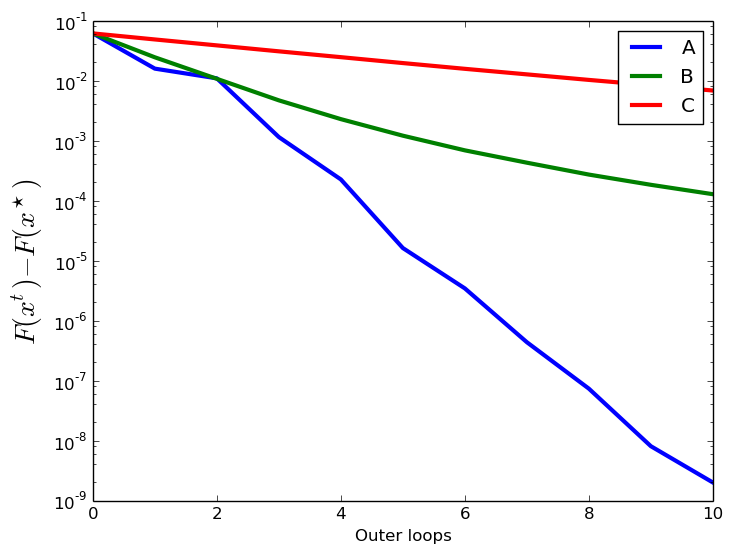

#Starting function value: 0, function value: 0.1685382470314124
#end of outer loop: 1, function value: 0.12334451293267616
#end of outer loop: 2, function value: 0.11843896556979104
#end of outer loop: 3, function value: 0.10871993343978094
#end of outer loop: 4, function value: 0.10780375722687582
#end of outer loop: 5, function value: 0.1075953879154453
#end of outer loop: 6, function value: 0.10758268501841226
#end of outer loop: 7, function value: 0.10757969293813253
#end of outer loop: 8, function value: 0.10757933132431881
#end of outer loop: 9, function value: 0.10757926620425319
#end of outer loop: 10, function value: 0.10757926016506966
finished!
#Starting function value: 0, function value: 0.1685382470314124
#end of outer loop: 1, function value: 0.13193266541040718
#end of outer loop: 2, function value: 0.11824417760558528
#end of outer loop: 3, function value: 0.11224755550803485
#end of outer loop: 4, function value: 0.1098493854306496
#end of outer loop: 5, function value

In [9]:
alg_list = ("A", "B", "C")
h_list = ( 1/(L),  1/(8*L), 1/(32*L) )  # stepsizes; do not change the first one
x0 = zeros(d)  # starting point
T = 10         # number of outer iters 
m = n          # number of inner iters

S2GDCompare(X, g, F, x0, h_list, T, m, alg_list, true)

## Problem A (Playing with parameters)

Play with different settings for the parameters of the method: 
- stepsize $h$
- number of outer iterations $T$
- number of inner iterations $m$

Some questions:
- What happens if $T=1$ and $m$ is large?
- What happens of $T$ is large and $m$ is small?
- What happens if you use large stepsizes: $h = 10/L$  ?
- What happens if you use small stepsizes: $h = 1/(100L) $
- Start the method from a point close to the optimal point (which you can approximately compute by running S2GD). What happens? Will the method be driven awat from the optimum, as SGD (stochastic gradient descent) would?
- Fix $T=10$. For the random dataset considered in this lab, what is the best value of $m$? And if $T=3$?

## Problem B (Gradient Descent)

Modify the input of the S2GD algorithm so that it becomes equivalent to <b>gradient descent (GD)</b> with fixed stepsize:

$$x^{k+1} = x^k - \frac{1}{L}\nabla f(x^k).$$

- Is this possible? That is, can we recover gradient descent as a special case of S2GD for a certain combination of parameters $h,T,m$?
- How does GD compare with S2GD?

## Problem C (Constrained S2GD)

S2GD can also be applied to solving a constrained optimization problem of the form

$$\min_{x\in Q} F(x),$$

where $Q$ is a closed convex set. In particular, this is done by replacing  the update step in the inner loop, which is of the form $x \leftarrow x - h \Delta$, by

$$x \leftarrow \arg \min_{z\in Q} \|z - (x - h \Delta)\|_2.$$ 

Write function $\verb"S2GDball"$ which implements the above method for a ball constraint of radius $R$:

$$Q = \{x\in \mathbb{R}^d \;:\; \|x\|_2\leq R\}.$$

For details about the theory behind a constrained version of S2GD, see [5].


## Problem D (Proximal S2GD)

Sometimes one is interested in solving a <b>composite</b> problem of the form 

$$\min_{x\in \mathbb{R}^d} F(x) + R(x),$$

where $R:\mathbb{R}^d \to \mathbb{R}\cup \{+\infty\}$ is  a <b>simple</b> closed (i.e.,lower-semicontinuous) convex function. Examples:

- <b> No regularization:</b> 

$$R(x) \equiv 0$$

- <b> Constrained optimization:</b> 

$$R(x) = \begin{cases} 0, & \text{if } x\in Q,\\
+\infty, & \text{otherwise.}\end{cases}
$$
It can be shown that $R$ is closed and convex iff $Q$ is a closed convex set.

- <b> Sparse optimization:</b> 

$$R(x) = \lambda \|x\|_1, \qquad \text{where} \qquad  \|x\|_1 = \sum_{i} |x_i| \qquad \text{and} \qquad \lambda>0$$ 

As $\lambda$ increases, the solutions tend to become sparser, which often a desired feature in applications.

S2GD can be modified to handle all of these cases; the complexity results hold without any changes. What changes is, as in the constrained S2GD described above, the update step. It becomes more involved:

$$x \leftarrow \arg \min_{z\in Q} \tfrac{1}{2}\|z - (x - h \Delta)\|_2^2 + h R(z). \tag{*}$$ 

- Verify that the above update reduces to standard S2GD when $R\equiv 0$ and to constrained S2GD, when $R$ is given as above.
- Code up S2GD with the L1 regularizer. In this case, one can solve the problem (*) in closed form. The operation is called <b>soft thresholding.</b> It is famous in optimization, signal processing and machine learning.

For details and the underlying theory, see [5].


## Problem E (Mini-batch S2GD)

It is possible to form the search direction by sampling more than a single function $i$. One can work with a subset instead (we have seen this in previous lectures for different algorithms). 

- Guess what would the update step look like if one was to sample a subset of $[n]=\{1,2,\dots,n\}$ of size $\tau$, uniformly at random
- Code up the method and call it $\verb"mS2GD"$. Run it for various values of $\tau$ and interpret the results.

For more details, see [5].


## Problem F (Efficient implementation for sparse data)

When $d$ is also large, the computation of a stochastic gradiend, i.e., of $\nabla f_i(x)$, can be large: $O(d)$. However, under certain conditions, it is possible to substantially accelerate even this step. The conditions are:
- the  data $X$ is sparse,  
- functions $f_i$ are of the form $f_i(x) = \phi_i(X_i^T x)$ for some (smooth convex) functions $\phi_i$,
- the reglarizer $R$ is separable: $R(x) = \sum_{i=1}^n R_i(x_i)$

Come up with a way to accelerate the update step. <i>Hint:</i> The stochastic gradient for index $i$ will always be  proportional to $X_i$ (and hence sparse). Think of a way to only update the cooridnates $j$ of $x$ for which the $j$th element of $X_{i}$ is nonzero. However, you need to make sure the algorithm does what it is supposed to do! It is just the implementation which needs to be changed, not the algorithm itself.


## Problem G (Other loss functions)

Replace the function $\verb"Loss_quadratic"$ with $\verb"Loss_logistic"$. Test the S2GD method on a real-life classification problem.
